In [2]:
%matplotlib notebook

import matplotlib as mpl
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [20]:
# read file
dfTimeseries = pd.read_json("timeseries_results/himalayas.json")
#elevation change
dfStats = gp.read_file("regression_results/himalayas.gpkg")
dfTimeseries

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsOnDataSetValue1,statistics.pointsOnDataSetValue1Ratio,statistics.pointsOnDataSetValue2,...,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx2_filtered,timeseries.dates,timeseries.averages,timeseries.change
0,-1600000,-100000,100000,0.863542,3.401935,106,-22.422802,10.0,9.433962,96,...,-9.820787,-11.176451,-21.182444,-5.338712,-7.113104,106,208320,"[1288569600000, 1296518400000, 1304208000000, ...","[-15.5730685004, None, None, -28.4195211863, N...","[0.0, None, None, -12.8464526859, None, -16.05..."
1,-1500000,0,100000,0.216172,0.749176,6,-10.264159,NaN,NaN,6,...,0.000000,0.000000,0.000000,0.000000,0.000000,6,107482,"[1288569600000, 1296518400000, 1304208000000, ...","[None, None, None, -8.505838041, None, None, N...","[None, None, None, None, None, None, None, Non..."
10,-1300000,400000,100000,113.223700,763.736827,24417,0.876133,2246.0,9.198509,22171,...,1.447304,-0.738574,2.042564,4.251057,1.980019,24417,80268,"[1288569600000, 1296518400000, 1304208000000, ...","[-2.035732069, 4.0275726166, -0.9680844958, 1....","[0.0, 6.0633046856, 1.0676475731, 3.1246890723..."
100,-400000,0,100000,18.586732,238.207789,1595,-8.298739,51.0,3.197492,1544,...,-5.856654,-10.745282,-4.647542,-22.741319,0.000000,1595,3416789,"[1288569600000, 1296518400000, 1304208000000, ...","[-49.2098987891, None, -4.772434362, -9.472499...","[0.0, None, 44.4374644271, 39.7373996836, None..."
101,-400000,600000,100000,178.219554,1221.480705,6625,-3.062366,359.0,5.418868,6266,...,-3.808004,-2.934693,-2.354841,-8.571045,-6.309150,6625,3226814,"[1288569600000, 1296518400000, 1304208000000, ...","[-3.9935437596, 11.7643795429, 0.2507601298, -...","[0.0, 15.7579233025, 4.2443038894, -1.62486087..."
102,-300000,-800000,100000,60.285411,303.781711,8308,3.862652,4774.0,57.462687,3534,...,-0.328393,0.924833,8.268857,12.222973,11.143885,8308,58453,"[1288569600000, 1296518400000, 1304208000000, ...","[0.0117870122, 16.8086761381, 9.1094802737, 12...","[0.0, 16.7968891258, 9.0976932615, 12.02393313..."
103,-300000,-700000,100000,68.111307,545.052121,27200,0.815595,6377.0,23.444853,20823,...,-1.122663,-0.683550,4.001266,-3.508464,-1.406535,27200,1187524,"[1288569600000, 1296518400000, 1304208000000, ...","[1.5858876788, 3.2274210644, 2.7595501768, -0....","[0.0, 1.6415333856, 1.173662498, -1.8732757884..."
104,-300000,-600000,100000,8.505991,177.209575,8507,-1.017548,3654.0,42.952862,4853,...,-1.533399,-3.962692,-4.055997,-2.700972,1.014616,8507,926648,"[1288569600000, 1296518400000, 1304208000000, ...","[0.8049029741, -6.7302195302, -3.7752577497, 1...","[0.0, -7.5351225042, -4.5801607238, 0.28915301..."
105,-300000,-500000,100000,0.326794,10.282097,532,0.856953,NaN,NaN,532,...,-1.517296,-13.524801,2.785189,6.112167,0.000000,532,1261806,"[1288569600000, 1296518400000, 1304208000000, ...","[None, None, 4.5798937748, 4.1712071856, None,...","[None, None, None, None, None, None, None, Non..."
106,-300000,-300000,100000,0.754639,223.883591,13840,3.050256,768.0,5.549133,13072,...,2.623523,3.469806,-0.065461,4.769503,0.000000,13840,1931109,"[1288569600000, 1296518400000, 1304208000000, ...","[3.9091361031, -3.1592530112, 4.5811564, 8.248...","[0.0, -7.0683891143, 0.6720202969, 4.339249688..."


In [21]:
for idx, line in dfTimeseries.iloc[:2].iterrows():
    dates=[datetime.fromtimestamp(x/1000) for x in line['timeseries.dates']]

In [22]:
# plot preparation:

dfStats.loc[(dfStats['statistics.GlacierMaskArea']<10.0), 'statistics.GlacierMaskArea.pointsize'] = 5
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=10.0) & (dfStats['statistics.GlacierMaskArea']<100.0), 'statistics.GlacierMaskArea.pointsize'] = 20
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=100.0) & (dfStats['statistics.GlacierMaskArea']<500.0), 'statistics.GlacierMaskArea.pointsize'] = 50
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=500.0) & (dfStats['statistics.GlacierMaskArea']<1000.0), 'statistics.GlacierMaskArea.pointsize'] = 80
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=1000.0) & (dfStats['statistics.GlacierMaskArea']<2000.0), 'statistics.GlacierMaskArea.pointsize'] = 125
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>2000.0), 'statistics.GlacierMaskArea.pointsize'] = 170

rivers = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/rivers_reprojected.shp")
countries = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/countries.shp")

colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',list(map(cm_,range(100))), N=100)
vmin=-2
vmax=2
markersize = dfStats['statistics.GlacierMaskArea.pointsize']
labels = ["<10", "10-100", "100-500", "500-1000", "1000-2000", ">2000"]
sizes = [5, 20, 50, 80, 125, 170]



In [74]:
def plotDash(row):
    gridcellMinX = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minX']
    gridcellMinY = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minY']
    size = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.size']
    regression_line = dfStats[(dfStats['gridCell.minX']==gridcellMinX)&(dfStats['gridCell.minY']==gridcellMinY)]
    print('Glacier mask area: %.3f km' % (dfTimeseries.iloc[row]['statistics.GlacierMaskArea']))
    print('Total points: %s' % (dfTimeseries.iloc[row]['statistics.result_total']))
    pdratio = dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask']/dfTimeseries.iloc[row]['statistics.result_total']*100
    print('Points on debris: %s  \t\t\t Points on debris ratio: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask'], pdratio))
    print('Points on TDX: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue2Ratio']))
    print('Points on SRTM: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue1Ratio']))
    print('RSquared: %.2f' % (regression_line['regression.rsquared']))
    print('Elevation change: %.3f m/year \t Robust elevation change: %.3f m/year' % (regression_line['regression.c.year'], regression_line['regression.robust.c.year']))
    print('Standard error: %.3f m \t\t Robust standard error: %.3f m ' % (regression_line['regression.c.se.year'], regression_line['regression.robust.c.se.year']))
    print('Regression constant: %.3f m \t\t Robust regression constant: %.3f m' % (regression_line['regression.const'],regression_line['regression.robust.const']))


    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(2,1,figsize=(8.8,9))

    countries.plot(ax=ax[0], edgecolor='grey', color='gainsboro', linewidth=0.5)
    rivers.plot(ax=ax[0], edgecolor='blue', linewidth=0.2)

    dfStats.plot(column='regression.c.year', markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax[0])
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax[1], orientation='horizontal', pad=0.2, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    bar.set_label('Elevation change per year [m]')

    ax[0].legend(handles=markers)
    leg = ax[0].legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)

    #ax[0].set_ylim(-2000000, 1000000)
    #ax[0].set_xlim(-900000, 1700000)
    # add number of gridcell
    for i, txt in enumerate(dfTimeseries['statistics.result_total']):
        ax[0].annotate(i, (dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minX']+ \
                               (size/2)+10000, dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minY']+\
                               (size/2)+10000), fontsize=5)
    # add X
    ax[0].annotate('x', (gridcellMinX+(size/2)-30000, gridcellMinY+(size/2)-30000), fontsize=12)

    # time series
    ax[1].plot(dates , dfTimeseries.iloc[row]['timeseries.averages'], linewidth=0.7)

    ax[1].set_xlim(min(dates), max(dates))
    ax[1].set_xlabel('Years')
    ax[1].set_ylabel('Elevation change [m]')
    #ax[1].yaxis.tick_right()
    #ax[1].yaxis.set_label_position("right")

    plt.tight_layout()
    

Glacier mask area: 762.097 km
Total points: 109053
Points on debris: 456  			 Points on debris ratio: 0.42 percent
Points on TDX: 98.04 percent
Points on SRTM: 1.96 percent
RSquared: 0.10
Elevation change: -1.642 m/year 	 Robust elevation change: -1.692 m/year
Standard error: 0.015 m 		 Robust standard error: 0.012 m 
Regression constant: 68.146 m 		 Robust regression constant: 70.325 m


<IPython.core.display.Javascript object>


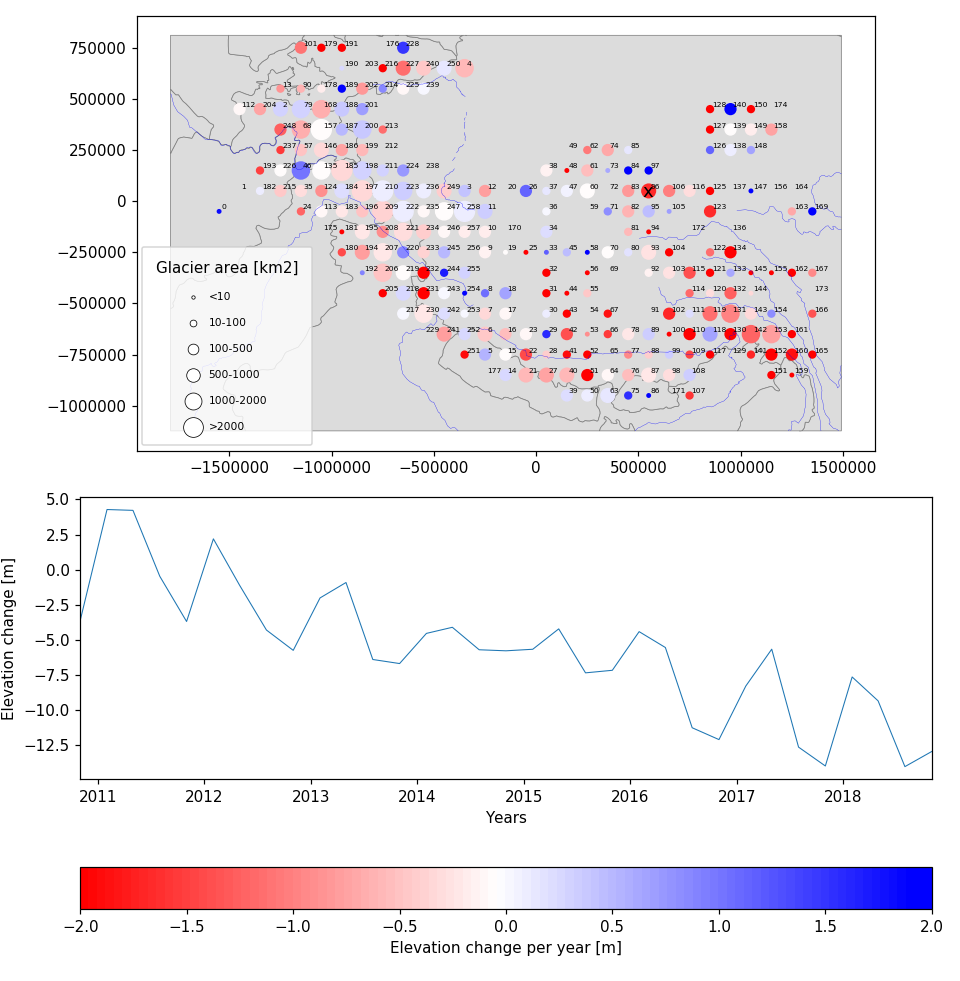

In [82]:
%matplotlib notebook
# change this
row=96
plotDash(row)

<IPython.core.display.Javascript object>


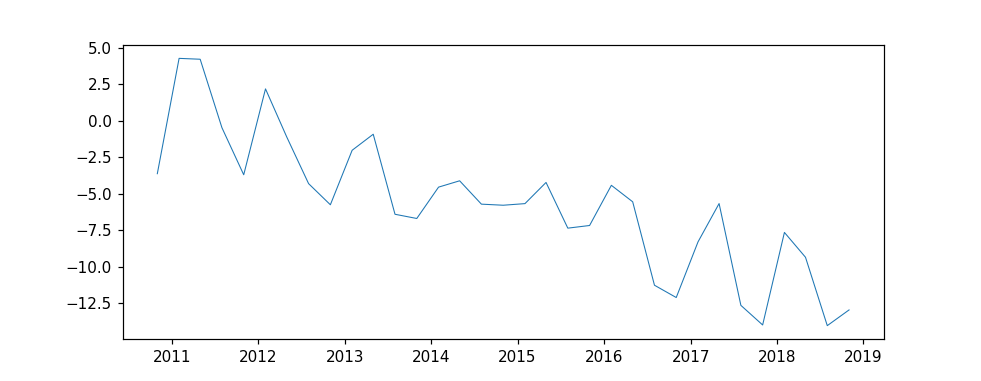

In [61]:
%matplotlib notebook
plt.figure(figsize=(9,3.5))

row=dfTimeseries.loc[(dfStats['gridCell.minX']==500000) & (dfStats['gridCell.minY']==0)]
 
dates=[datetime.fromtimestamp(x/1000) for x in row.iloc[0]['timeseries.dates']]
plt.plot(dates , row.iloc[0]['timeseries.averages'], linewidth=0.7)